## Introducion to Tensor Networks and Matrix Product states
PSI Numerical Methods course, Jan 2025

Adapted from the PSI Start minicourse developed by Subhayan Sahu and Yijian Zou

In [1]:
### If you have not installed the TensorOperations package, uncomment and run the following line
using Pkg; Pkg.add("TensorOperations")



   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


 TensorOperations help in dynamical tensor network contraction using einstein notation and ncon
 https://jutho.github.io/TensorOperations.jl
 
 https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/

In [2]:
using LinearAlgebra, TensorOperations

## MPS and TN basics

In [29]:
### Tensor contraction examples

using TensorOperations
α = randn()
A = randn(5, 5, 5, 5, 5, 5)
B = randn(5, 5, 5)
C = randn(5, 5, 5)
D = zeros(5, 5, 5)
@tensor begin
    D[a, b, c] = A[a, e, f, c, f, g] * B[g, b, e] + α * C[c, a, b]
    E[a, b, c] := A[a, e, f, c, f, g] * B[g, b, e] + α * C[c, a, b]
end

5×5×5 Array{Float64, 3}:
[:, :, 1] =
   4.9253   -22.5666    4.42966     1.49905   4.86587
 -13.3743     4.33463  -9.18454    -1.94948  -4.82656
   6.49773  -13.1451    1.593       1.80364   5.97422
  -6.07573    4.44148   0.0596129   3.85065  13.0133
  13.1535    -7.13025  20.9864     -8.40996  14.5382

[:, :, 2] =
 -9.82213   -7.44551   -7.63466     4.2755   -4.66815
 -1.62414   -2.32298   29.8972    -11.8014   -3.46588
  1.81391   -0.989661   0.574721   -6.4541    1.55435
 15.537     10.4435    -0.6509     -3.38908   4.27731
 -1.64895  -16.0571    -0.454506   -2.94044  13.1802

[:, :, 3] =
   4.53705   -34.1298    19.0706    1.40922    -0.133421
  -9.19294     9.03241    4.48813   5.1289    -12.726
  15.3912    -10.9021     2.02947   1.25294    -1.22782
  -0.616361   19.4091   -17.2506    0.273214    5.66739
 -10.3513     10.2785    -8.83062  -8.11965    -9.82819

[:, :, 4] =
  -0.96416    7.67476   -6.89734  -0.292871   23.5229
 -11.0244    -0.173065   6.78514  12.2402     19.7599


In [24]:
struct myMPS{T<:Number}
    """
    This creates a parameterized type myMPS where:

    - T must be a subtype of Number (like Float64, Complex, etc.)
    - TensorList is a 1D array containing 3D arrays of type T
    - Each 3D tensor represents (left bond, system spin, right bond) indices
    """
    TensorList::Array{Array{T,3},1} #List of myMPS tensors
    #Tensor indices - left bond, system spin, right bond
end

""" The following helper functions extends some base functions to act on our struct type """
Base.length(M::myMPS) = length(M.TensorList)  #number of sites
phys_dim(M::myMPS) = size(M.TensorList[1],2)  #physical dimension
max_bond_dim(M::myMPS) = findmax([size(ten,1) for ten in M.TensorList])[1] #bond dimension
Base.copy(M::myMPS) = myMPS(copy(M.TensorList)) #copy an MPS

In [25]:
# Create a simple MPS with 2 sites
tensor1 = zeros(Float64, 2,2,2)  # 2×2×2 tensor
tensor2 = zeros(Float64, 2,2,2)  # 2×2×2 tensor
mps = myMPS([tensor1, tensor2])

println(length(mps))        # 2 (sites)
println(phys_dim(mps))      # 2 (physical dimension)
println(max_bond_dim(mps))  # 2 (maximum bond dimension)

2
2
2


## MPS to dense and dense to MPS

In [3]:
function randMPS(T::Type,N,d,D)
    ## generate a random MPS with size N, physial dimenson d and bond dimension D
    ## The MPS is in left canonial form
    Ts = Array{T,3}[]
    dL = 1;
    dR = 1;
    for n in 1:N
        dL = dR  ## left bond dimension
        dR = min(D,dL*d,d^n,d^(N-n)) ## right bond dimension
        X = randn(dL*d,dR)
        A = reshape(X,(dL,d,dR))
        push!(Ts,A)
    end
    M = myMPS(Ts)
end

randMPS (generic function with 1 method)

In [26]:
# Create a random MPS with N sites

N = 8;
d = 2;
D = 10;
mps = randMPS(Float64,N,d,D);

println(length(mps))        # (sites)
println(phys_dim(mps))      # (physical dimension)
println(max_bond_dim(mps))  # (maximum bond dimension)

8
2
10


In [4]:
function MPS_to_dense(M::myMPS{T}) where T
    ## Only run this for small systems!!
    d = phys_dim(M)
    L = length(M)
    tmp = M.TensorList[1]
    for i in 2:L
        A = M.TensorList[i]
        dR = size(A,3)
        @tensor tmp2[l,s1,s2,r] := tmp[l,s1,r1]*A[r1,s2,r] ## Notice the einstein notation
        tmp = reshape(tmp2,(1,d^i,dR))
    end
    psi = reshape(tmp,d^L)
end

MPS_to_dense (generic function with 1 method)

In [27]:
## Convert MPS to dense vector

tensor1 = ones(Float64, 1,2,2)  # 2×2×2 tensor
tensor2 = ones(Float64, 2,2,1)  # 2×2×2 tensor
mps = myMPS([tensor1, tensor2])

MPS_to_dense(mps)

4-element Vector{Float64}:
 2.0
 2.0
 2.0
 2.0

In [5]:
function dense_to_MPS(psi::Vector{T},d) where T
    L = convert(Int,round(log(length(psi))/log(d)))
    psi = reshape(psi,(d,d^(L-1)))
    U,S,V = svd(psi)
    A1 = reshape(U,(1,d,d))
    Ts = Array{T,3}[]
    push!(Ts,A1)
    for i in 2:L
        SVt = diagm(S)*V'
        dL = length(S)
        SVt = reshape(SVt,(dL*d,d^(L-i)))
        U,S,V = svd(SVt)
        dR = size(U,2)
        A = reshape(U,(dL,d,dR))
        push!(Ts,A)
    end
    M = myMPS(Ts)
    return M
end

dense_to_MPS (generic function with 1 method)

### Exercise: convert MPS to dense and check entropy bound

In [6]:
N = 8;
d = 2;
D = 10;
M = randMPS(Float64,N,d,D);
psi = MPS_to_dense(M);
for i in 1:N-1
    psi = reshape(psi,(d^i,d^(N-i)))
    S = svdvals(psi)
    S = S./sqrt(sum(S.^2))
    EE = -sum((S.^2).*log.(S.^2))
    println("Across bond $i, EE=$EE")
end
Smax = log(D)
println("Entropy upper bond: $Smax")

Across bond 1, EE=0.006461397440551949
Across bond 2, EE=0.20902228875609968
Across bond 3, EE=0.6336766969570384
Across bond 4, EE=0.9332366842000315
Across bond 5, EE=0.712921416771392
Across bond 6, EE=0.4225472991446794
Across bond 7, EE=0.014424588857828075
Entropy upper bond: 2.302585092994046


### Exercise: dense->MPS->dense

In [7]:
psi = randn(2^8);
psi = psi/norm(psi);
M = dense_to_MPS(psi,2);
psi2 = MPS_to_dense(M);
dot(psi,psi2)/sqrt(dot(psi2,psi2)) ## overlap

1.0000000000000009

### Exercise: gauge transformation

In [28]:
M = randMPS(Float64,N,d,D)
M2 = copy(M)
for bond in 1:N-1
    Db = size(M.TensorList[bond],3)
    X = I+randn(Db,Db)
    Xinv = inv(X)
    M2.TensorList[bond] = ncon([M2.TensorList[bond],X],[[-1,-2,1],[1,-3]])
    M2.TensorList[bond+1] = ncon([M2.TensorList[bond+1],Xinv],[[1,-2,-3],[-1,1]])
end
psi1 = MPS_to_dense(M)
psi2 = MPS_to_dense(M2)
dot(psi1,psi2)/(sqrt(dot(psi1,psi1)*dot(psi2,psi2)))

1.0000000000000002

## Canonical form

In [9]:
function truncate(S::Vector{<:Real}, max_bd::Int, max_err::Float64)
    ## Given an array S (descending), determine the truncation 
    ## based on which of max bond dimesion or max err is reached
    err = 0.0
    set_bd = max_bd
    for i in length(S):-1:1
        err = err + S[i]^2
        if(err>max_err)
            if(i<max_bd)
                set_bd = i
            end
            break
        end
    end
    return set_bd
end

truncate (generic function with 1 method)

In [10]:
function canonicalize_left_one_site(M::myMPS, site::Int;truncation = false, max_bd = 1024, max_err = 1E-10)
    ## A1 := M[site], A2 := M[site+1]
    ## A1 = USV' => A1=U, A2 = SVt (update)
    ## Truncate S if truncation = true
    ## return S and the updated myMPS M
    A1 = M.TensorList[site]
    DL,d,DR = size(A1)
    A1_mat = reshape(A1, (DL*d,DR))
    U = nothing; S=nothing; V=nothing;
    try
        U,S,V = svd(A1_mat,alg=LinearAlgebra.DivideAndConquer())
    catch
        U,S,V = svd(A1_mat,alg=LinearAlgebra.QRIteration())
    end
    if(norm(S)<eps(Float64))
         throw("zero norm")
    end
    S = S./norm(S)
    if(truncation == true)
        set_bd = truncate(S,max_bd,max_err)
        trunc_err = norm(S[set_bd+1:end])^2
        if(trunc_err>1E-6)
            println("truncation error:",trunc_err)
        end
        S = S[1:set_bd]
        U = U[:,1:set_bd]
        V = V[:,1:set_bd]
    end
    M.TensorList[site] = reshape(U, (DL,d,length(S)))
    if(site<length(M))
        SVt = diagm(0=>S)*V'
        M.TensorList[site+1] = ncon([SVt, M.TensorList[site+1]],[[-1,1],[1,-2,-3]])
    end
    return S, M
end

function canonicalize_right_one_site(M::myMPS, site::Int;truncation = false, max_bd = 1024, max_err = 1E-10)
    ## A1 := M[site], A2 :=M[site-1]
    ## A1 = USV' => A1=V', A2 = US
    ## Truncate S if truncation = true
    A1 = M.TensorList[site]
    DL,d,DR = size(A1)
    A1_mat = reshape(A1, (DL,DR*d))
    U = nothing; S=nothing; V=nothing;
    try
        U,S,V = svd(A1_mat,alg=LinearAlgebra.DivideAndConquer())
    catch
        U,S,V = svd(A1_mat,alg=LinearAlgebra.QRIteration())
    end
    if(norm(S)<eps(Float64))
         throw("zero norm")
    end
    S = S./norm(S)
    if(truncation == true)
        set_bd = truncate(S,max_bd,max_err)
        trunc_err = norm(S[set_bd+1:end])^2
        if(trunc_err>1E-6)
            println("truncation error:",trunc_err)
        end
        S = S[1:set_bd]
        U = U[:,1:set_bd]
        V = V[:,1:set_bd]
    end
    M.TensorList[site] = reshape(V', (length(S),d,DR))
    if(site>1)
        US = U*diagm(0=>S)
        M.TensorList[site-1] = ncon([US, M.TensorList[site-1]],[[1,-3],[-1,-2,1]])
    end
    return S, M
end

function canonicalize_left(M::myMPS;truncation = false, max_bd = 1024, max_err = 1E-10)
    ## Return a left canonical form of the state (normalized automatically)
    N = length(M)
    for i in 1:N
        ~, M = canonicalize_left_one_site(M, i, truncation=truncation,max_bd=max_bd,max_err=max_err)
    end
    return M
end

function canonicalize_right(M::myMPS;truncation = false, max_bd = 1024, max_err = 1E-10)
    ## Return a right canonical form of the state (normalized automatically)
    N = length(M)
    for i in N:-1:1
        ~, M = canonicalize_right_one_site(M, i, truncation=truncation,max_bd=max_bd,max_err=max_err)
    end
    return M
end

canonicalize_right (generic function with 1 method)

In [11]:
M = randMPS(Float64,N,d,D);
M = canonicalize_left(M);
M1 = copy(M);
## You can check here that every tensor satisfies LCC
M = canonicalize_right(M);
M2 = copy(M);
## You can check here that every tensor satisfies RCC
psi1 = MPS_to_dense(M1);
psi2 = MPS_to_dense(M2);
abs(dot(psi1,psi2)) # LCC and RCC represents the same state!

1.0000000000000004

## TEBD

In [12]:
function product_state_init(T::Type, d::Int, N::Int) 
    ## Initialize a product state |0101010101...>
    ## T - data type
    ## d - local dimension
    ## N - number of sites
    Ten = zeros(T,1,d,1)
    Ten[1,1,1] = 1.0
    myMPSTensors = Array{T,3}[]
    for i in 1:N
        push!(myMPSTensors, Ten)
    end
    return myMPS(myMPSTensors)
end

product_state_init (generic function with 1 method)

In [13]:
function evolution_two_site(M::myMPS, U::Matrix, site::Int, dir = "l"; truncation = false, max_bd = 1024, max_err=1E-10)
    ## Evolve the pure state by U 
    ## Assuming U is two-site
    ## further assuming the two sites are the center of canonical form if truncation = true (important!)
    ## site is the first site # of the unitary (1 to N-1)
    ## the [site] of the two sites is put into left canonical form (if dir = "l")
    ## the [site+1] of the two sites is put into right canonical form (if dir = "r")
    ## return S and M (automatically normalize the state)
    myMPSTensors = M.TensorList
    @assert site<length(M)
    A1 = myMPSTensors[site]
    A2 = myMPSTensors[site+1]
    d1 = size(A1,2)
    d2 = size(A2,2)
    DL = size(A1,1)
    DR = size(A2,3)
    U = reshape(U,(d1,d2,d1,d2)) # site 1 ket, site 2 ket, site 1 bra, site 2 bra
    A_evol = ncon([A1,A2,U],[[-1,1,2],[2,3,-4],[1,3,-2,-3]])
    A_evol_mat = reshape(A_evol,(DL*d1,DR*d2))
    U2 = nothing; S2=nothing; V2=nothing;
    try
        U2,S2,V2 = svd(A_evol_mat,alg=LinearAlgebra.DivideAndConquer())
    catch
        U2,S2,V2 = svd(A_evol_mat,alg=LinearAlgebra.QRIteration())
    end
    S2 = S2./norm(S2)
    if(truncation == true)
        set_bd = truncate(S2, max_bd, max_err)
        trunc_err = norm(S2[set_bd+1:end])^2
        if(trunc_err>1E-6)
            println("truncation error:",trunc_err)
        end
        S2 = S2[1:set_bd]
        U2 = U2[:,1:set_bd]
        V2 = V2[:,1:set_bd]
    end
    if(dir == "l")
        AL = reshape(U2, (DL,d1,length(S2)))
        AR = reshape(diagm(0=>S2)*V2',(length(S2),d2,DR))
    else
        AL = reshape(U2*diagm(0=>S2), (DL,d1,length(S2)))
        AR = reshape(V2',(length(S2),d2,DR))
    end
    M.TensorList[site] = AL
    M.TensorList[site+1] = AR    
    return S2, M
end

evolution_two_site (generic function with 2 methods)

In [14]:
function TEBD_layer(M::myMPS, U::Matrix, eo = "o";truncation = false, max_bd = 1024, max_err = 1E-10)
    ## Apply TEBD layer at each even/odd sites
    ## Note - right canonical form assumed in beginning, and left canonical form in the end
    N = length(M)
    d = phys_dim(M)
    if(eo == "o")
        site0 = 1
    else
        S, M = canonicalize_left_one_site(M,1,truncation = truncation, max_bd = max_bd, max_err = max_err)
        site0 = 2
    end
    for site in site0:2:N-1
        S, M = evolution_two_site(M, U, site, "l", truncation = truncation, max_bd = max_bd, max_err = max_err)
        S, M = canonicalize_left_one_site(M,site+1,truncation = truncation, max_bd = max_bd, max_err = max_err)
    end
    return M
end

TEBD_layer (generic function with 2 methods)

In [32]:
function TEBD_Ising(M0::myMPS,g::Float64,dt::Float64, chimax::Int = 128,err::Float64 = 1E-10, etol = 1E-10, Tmax = 10.0)
    ## Time evolution exp(-TH)|M0> until T=Tmax or energy converges to precision etol
    ## H = - XX - gZ (boundary field cut half)
    ## using second order trotter with time step dt
    ## truncation according to error <= err or bond dimesion reaches chimax
    sigmaX = [[0.0 1.0];[1.0 0.0]]
    sigmaZ = [[1.0 0.0];[0.0 -1.0]]
    Id = [[1.0 0.0];[0.0 1.0]]
    @tensor h12[a,b,c,d] := -sigmaX[a,c]*sigmaX[b,d]-g*sigmaZ[a,c]*Id[b,d]/2-g*Id[a,c]*sigmaZ[b,d]/2
    h12_mat = reshape(h12,(4,4))
    U_half = exp(-dt*h12_mat/2) ##matrix exponential
    U = U_half*U_half 
    
    maxstep = convert(Int,round(Tmax/dt))
    L = length(M0)
    ## compute initial energy
    M = canonicalize_left(M0)
    Ein = 0.0;
    for i in L:-1:2
        AR = M.TensorList[i]
        AL = M.TensorList[i-1]
        Ei = ncon([h12,AL,conj(AL),AR,conj(AR)],[[2,5,3,7],[1,2,4],[1,3,6],[4,5,8],[6,7,8]])
        Ein = Ein+real(Ei[1])
        ~,M = canonicalize_right_one_site(M,i)
    end
    println("Starting TEBD for Ising model, g=$g, L=$L, chimax=$chimax, dt=$dt")
    for step in 1:maxstep
        println("Step $step")
        M = TEBD_layer(M,U_half,"o",truncation = true, max_bd = chimax, max_err = err)
        M = canonicalize_right(M)
        M = TEBD_layer(M,U,"e",truncation = true, max_bd = chimax, max_err = err)
        M = canonicalize_right(M)
        M = TEBD_layer(M,U_half,"o",truncation = true, max_bd = chimax, max_err = err)
        Eout = 0.0;
        for i in L:-1:2
            AR = M.TensorList[i]
            AL = M.TensorList[i-1]
            Ei = ncon([h12,AL,conj(AL),AR,conj(AR)],[[2,5,3,7],[1,2,4],[1,3,6],[4,5,8],[6,7,8]])
            Eout = Eout+real(Ei[1])
            ~,M = canonicalize_right_one_site(M,i)
        end
        bd = max_bond_dim(M)
        println("Maximal bond dimension: $bd")
        if(Ein-Eout<etol)
            println("STOP due to energy convergence. Final energy:$Eout")
            break
        else
            dE = Eout-Ein
            println("Energy = $Eout, energy change = $dE")
            Ein = Eout
        end
        if(step == maxstep)
            println("STOP due to time limit. Final energy:$Eout")
        end
    end
    return M
end

TEBD_Ising (generic function with 5 methods)

In [33]:
L = 24
d = 2
g = 1.2 #Ising field
chimax = 128 #max bond dim
dt = 0.01 #trotter step
err = 1E-7 #max truncation error
etol = 1E-7 #energy convergence tolerance
Tmax = 2.0 #max imaginary time 

M0 = product_state_init(Float64,d,L);
M = TEBD_Ising(M0,g,dt,chimax,err,etol,Tmax);

Starting TEBD for Ising model, g=1.2, L=24, chimax=128, dt=0.01
Step 1
Maximal bond dimension: 2
Energy = -28.039009991534037, energy change = -0.4390099915340464
Step 2
Maximal bond dimension: 2
Energy = -28.438417990973075, energy change = -0.39940799943903826
Step 3
Maximal bond dimension: 2
Energy = -28.801634113643694, energy change = -0.3632161226706181
Step 4
Maximal bond dimension: 2
Energy = -29.131850944231473, energy change = -0.33021683058777995
Step 5
Maximal bond dimension: 2
Energy = -29.43203726211103, energy change = -0.3001863178795574
Step 6
Maximal bond dimension: 2
Energy = -29.704938028091522, energy change = -0.2729007659804914
Step 7
Maximal bond dimension: 2
Energy = -29.953079065652094, energy change = -0.24814103756057193
Step 8
Maximal bond dimension: 2
Energy = -30.17877512876706, energy change = -0.2256960631149667
Step 9
Maximal bond dimension: 2
Energy = -30.384140289718633, energy change = -0.20536516095157253
Step 10
Maximal bond dimension: 2
Energy = 

In [19]:
function Ising_energy_exact(N::Int64,g::Float64)
    ## Open boundary condition, boundary field cut half
    H_majorana = zeros(2*N,2*N)
    for i in 1:N
        if(i==1 || i==N)
            H_majorana[2*i-1,2*i] = -g/2
        else
            H_majorana[2*i-1,2*i] = -g
        end
        if (i<N)
            H_majorana[2*i,2*i+1] = -1
        end
    end
    H_majorana = H_majorana - H_majorana'
    T,Z = schur(H_majorana)
    Es = [T[2*i-1,2*i] for i in 1:N]
    E0 = -sum(abs.(Es))
    return E0
end

Ising_energy_exact (generic function with 1 method)

In [20]:
Ising_energy_exact(L,g)

-32.78014564399475

## Aside: use SVD for image compression!

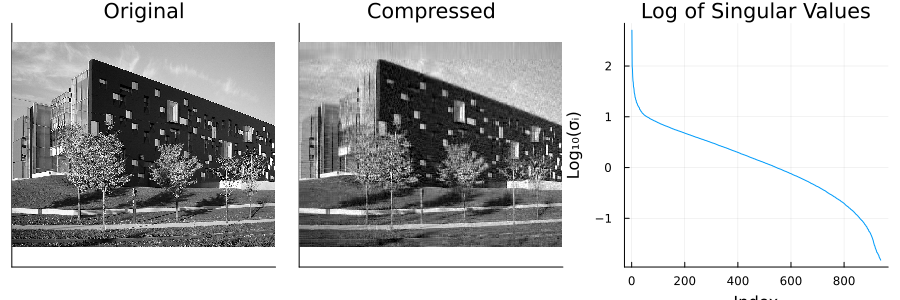

Compression Statistics:
----------------------
Number of singular values used: 50
Compression ratio: 10.55x
Relative error: 18.21%

Explained Variance by Number of Components:
k = 1: 83.25% variance explained
k = 5: 90.89% variance explained
k = 10: 93.24% variance explained
k = 20: 94.9% variance explained
k = 50: 96.68% variance explained
k = 100: 97.98% variance explained


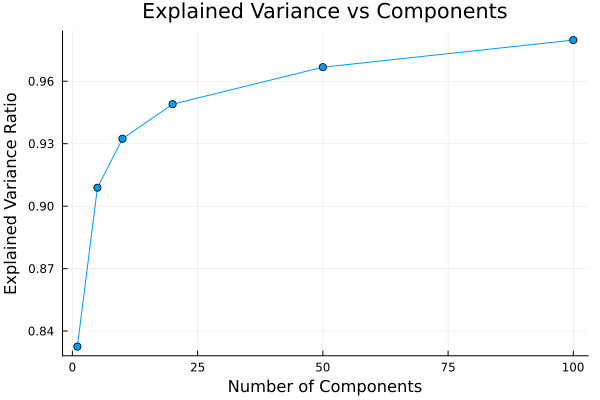

(Gray{Float64}[Gray{Float64}(0.7131063241726815) Gray{Float64}(0.7128286042155669) … Gray{Float64}(0.6359367765866473) Gray{Float64}(0.6347814984111303); Gray{Float64}(0.7146476429124218) Gray{Float64}(0.7141362192487931) … Gray{Float64}(0.6333576596199988) Gray{Float64}(0.6318148816560977); … ; Gray{Float64}(0.13567343877030485) Gray{Float64}(0.11506535359211591) … Gray{Float64}(0.3665773372386212) Gray{Float64}(0.3713429099832445); Gray{Float64}(0.09210616652287987) Gray{Float64}(0.07639456913775437) … Gray{Float64}(0.33051232454178936) Gray{Float64}(0.32774127098713307)], 10.551407269338304, 0.18208805109166337)

In [31]:
using Images
using LinearAlgebra
using FileIO
using Plots

function compress_image_svd(image_path::String, k::Int)
    # Read and convert image to grayscale
    img = load(image_path)
    gray_img = Gray.(img)
    
    # Convert to matrix of float values
    A = Float64.(gray_img)
    
    # Perform SVD
    U, S, V = svd(A)
    
    # Truncate to k singular values
    U_k = U[:, 1:k]
    S_k = Diagonal(S[1:k])
    V_k = V[:, 1:k]
    
    # Reconstruct compressed image
    A_compressed = U_k * S_k * V_k'
    
    # Ensure values are in valid range [0,1]
    A_compressed = clamp.(A_compressed, 0, 1)
    
    # Convert back to image format
    compressed_img = Gray.(A_compressed)
    
    # Calculate compression ratio and error
    original_size = length(A)
    compressed_size = k * (size(A,1) + size(A,2) + 1)
    compression_ratio = original_size / compressed_size
    error = norm(A - A_compressed) / norm(A)
    
    return compressed_img, compression_ratio, error, S
end

function analyze_compression_quality(S::Vector{Float64}, ks::Vector{Int})
    # Calculate explained variance ratio for different k values
    total_variance = sum(S.^2)
    explained_variances = [sum(S[1:k].^2) / total_variance for k in ks]
    return explained_variances
end

function plot_comparison(original_img, compressed_img, singular_values)
    # Create a figure with three subplots
    p1 = plot(Gray.(original_img), title="Original", axis=nothing)
    p2 = plot(compressed_img, title="Compressed", axis=nothing)
    p3 = plot(log10.(singular_values), 
             title="Log of Singular Values",
             xlabel="Index",
             ylabel="Log₁₀(σᵢ)",
             label=nothing)
    
    # Combine plots
    p = plot(p1, p2, p3, layout=(1,3), size=(900,300))
    return p
end

function demonstrate_compression(image_path::String, k::Int)
    # Load original image
    original = load(image_path)
    original_gray = Gray.(original)
    
    # Compress image
    compressed, ratio, error, S = compress_image_svd(image_path, k)
    
    # Create and display comparison plot
    p = plot_comparison(original_gray, compressed, S)
    display(p)
    
    # Print statistics
    println("Compression Statistics:")
    println("----------------------")
    println("Number of singular values used: $k")
    println("Compression ratio: $(round(ratio, digits=2))x")
    println("Relative error: $(round(error * 100, digits=2))%")
    
    # Analyze different compression levels
    ks = [1, 5, 10, 20, 50, 100]
    explained_vars = analyze_compression_quality(S, ks)
    
    println("\nExplained Variance by Number of Components:")
    for (k, var) in zip(ks, explained_vars)
        println("k = $k: $(round(var * 100, digits=2))% variance explained")
    end
    
    # Plot explained variance
    p_var = plot(ks, explained_vars, 
                 title="Explained Variance vs Components",
                 xlabel="Number of Components",
                 ylabel="Explained Variance Ratio",
                 marker=:circle,
                 label=nothing)
    display(p_var)
    
    return compressed, ratio, error
end

image_path = "image.jpg"
k = 50  # number of singular values to keep
# output_path = "compressed_comparison.jpg"

compressed, ratio, error = demonstrate_compression(image_path, k)